# Intro

### This project generates the music using LSTM enural networks

We learn the notes based on mozart musics while you can change it from any other musicians available in the provided dataset your musicians/musics. Feel free to update dataset input files based on your prefrences

In [1]:
import numpy as np # linear algebra
import os

#Importing Libraries
import tensorflow 
import numpy as np 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

np.random.seed(28)


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
#Loading dataset
directory = "./dataset/mozart/"

all_midis= []
for path in os.listdir(directory):
    if path.endswith(".mid"):
        try:
            full_path = directory + path
            midi = converter.parse(full_path)
            all_midis.append(midi)
        except Exception as e:
            print(e)

D:\Apps\Anaconda\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
D:\Apps\Anaconda\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
D:\Apps\Anaconda\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
D:\Apps\Anaconda\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRAC

In [7]:
print("Total number of files: ", len(all_midis))

Total number of files:  21


In [9]:
def extract_notes(midi_file):
    notes = []
    pick = None
    for midi in midi_file:
        songs = instrument.partitionByInstrument(midi)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

notes = extract_notes(all_midis)
print("Total notes:", len(notes))



Total notes: 55802


In [10]:
print("First 10 notes:\n", notes[:10])

First 10 notes:
 ['2.6.9', '9.2', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5']


In [11]:
# add lily to the path, change the path directory based on your lily folder
# see more detail at:        https://lilypond.org/download.html

us = environment.UserSettings()
# us.create()
us['lilypondPath'] = <<PATH TO YOUR LiLyPond DIRECTORY>>

In [12]:
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(notes[:100])

In [13]:
count_num = Counter(notes)
print("Total unique notes:", len(count_num))

Total unique notes: 229


In [34]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in notes
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in notes:", Average(Recurrence))
print("Most frequent note in notes appeared:", max(Recurrence), "times")
print("Least frequent note in notes appeared:", min(Recurrence), "time")

Average recurrenc for a note in notes: 243.6768558951965
Most frequent note in notes appeared: 2355 times
Least frequent note in notes appeared: 1 time


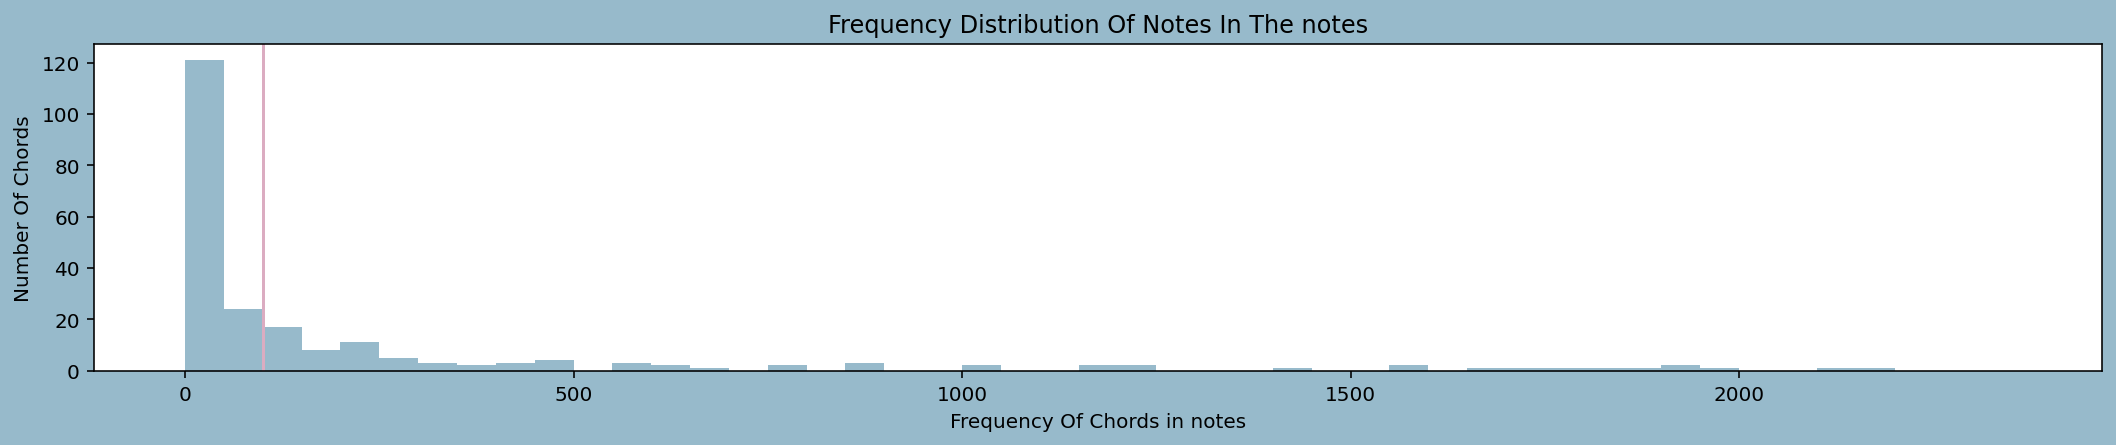

In [35]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The notes")
plt.xlabel("Frequency Of Chords in notes")
plt.ylabel("Number Of Chords")
plt.show()

In [36]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 145


In [37]:
for element in notes:
    if element in rare_note:
        notes.remove(element)

print("Length of cleaned notes", len(notes))

Length of cleaned notes 52756


In [38]:
# Storing all the unique characters present in my notes to bult a mapping dic. 
symb = sorted(list(set(notes)))

L_notes = len(notes) #length of notes
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_notes)
print("Number of unique characters:", L_symb)

Total number of characters: 52756
Number of unique characters: 107


In [39]:
length = 40
features = []
targets = []
for i in range(0, L_notes - length, 1):
    feature = notes[i:i + length]
    target = notes[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the notes:", L_datapoints)

Total number of sequences in the notes: 52716


In [40]:
L_datapoints

52716

In [41]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [42]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_2 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 107)               27499     
                                                                 
Total params: 1933419 (7.38 MB)
Trainable params: 1933

In [45]:
# try to switch to GPU is available
physical_devices = tensorflow.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


In [46]:
# Set to use the first GPU (if available)
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    try:
        tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [35]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=100)


Epoch 1/100
166/166 [==============================] - 106s 625ms/step - loss: 4.1548
Epoch 2/100
166/166 [==============================] - 106s 640ms/step - loss: 4.0793
Epoch 3/100
166/166 [==============================] - 106s 637ms/step - loss: 4.0750
Epoch 4/100
166/166 [==============================] - 106s 636ms/step - loss: 4.0718
Epoch 5/100
166/166 [==============================] - 106s 640ms/step - loss: 4.0693
Epoch 6/100
166/166 [==============================] - 105s 635ms/step - loss: 4.0676
Epoch 7/100
166/166 [==============================] - 105s 633ms/step - loss: 4.0657
Epoch 8/100
166/166 [==============================] - 106s 637ms/step - loss: 4.0651
Epoch 9/100
166/166 [==============================] - 105s 635ms/step - loss: 4.0638
Epoch 10/100
166/166 [==============================] - 108s 650ms/step - loss: 4.0642
Epoch 11/100
166/166 [==============================] - 105s 634ms/step - loss: 4.0602
Epoch 12/100
166/166 [==============================

In [36]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)

In [38]:
#save the generated melody
Melody.write('midi','./output/Gen1.mid')

#play audio
IPython.display.Audio("./output/Gen1.mid")